# Absenteeism Prediction
## Problem Statement
>  Building a model to predict the absenteeism of employees based on features like Reason for Abesnce , Education ,Transportation expenses , Age , Daily work hours etc.


### Import libraries

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


### Load the dataset

In [10]:
data = pd.read_csv("Absenteeism_preprocessed_data.csv")
data.head()

,Reason_1,Reason_2,Reason_3,Reason_4,Month Value,Day of the Week,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours
0,0,0,0,1,7,1,289,36,33,239.554,30,0,2,1,4
1,0,0,0,0,7,1,118,13,50,239.554,31,0,1,0,0
2,0,0,0,1,7,2,179,51,38,239.554,31,0,0,0,2
3,1,0,0,0,7,3,279,5,39,239.554,24,0,2,0,4
4,0,0,0,1,7,3,289,36,33,239.554,30,0,2,1,2


### Creating targets/classes

In [11]:
# Creating class for model
targets = data["Absenteeism Time in Hours"].map(lambda x : 1 if x> data["Absenteeism Time in Hours"].median() else 0)

In [12]:
# Check if targets are balanced or not
targets.sum()/targets.shape[0]

0.45571428571428574

In [13]:
# ADDING TARGETS 
data["Excessive Absenteeism"] = targets
data_with_targets = data.drop(["Absenteeism Time in Hours","Day of the Week","Month Value","Daily Work Load Average"],axis = 1)
data_with_targets.shape

(700, 12)

### Inputs and Targets

In [14]:
unscaled_inputs = data_with_targets.iloc[:,:-1]
targets = data_with_targets.iloc[:,-1]
unscaled_inputs.head()

,Reason_1,Reason_2,Reason_3,Reason_4,Transportation Expense,Distance to Work,Age,Body Mass Index,Education,Children,Pets
0,0,0,0,1,289,36,33,30,0,2,1
1,0,0,0,0,118,13,50,31,0,1,0
2,0,0,0,1,179,51,38,31,0,0,0
3,1,0,0,0,279,5,39,24,0,2,0
4,0,0,0,1,289,36,33,30,0,2,1


### Scaling
    

In [15]:
# import the libraries needed to create the Custom Scaler which is actually the StandardScaler module
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

# create the Custom Scaler class

class CustomScaler(BaseEstimator,TransformerMixin): 
    
    # init or what information we need to declare a CustomScaler object
    def __init__(self,columns,copy=True,with_mean=True,with_std=True):
        
        self.scaler = StandardScaler(copy,with_mean,with_std)
        self.columns = columns
        self.mean_ = None
        self.var_ = None
         
    # the fit method, which, again based on StandardScale basically calculates means and variance and store them
    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns], y)
        self.mean_ = np.mean(X[self.columns])
        self.var_ = np.var(X[self.columns])
        return self
    
    # the transform method which does the actual scaling

    def transform(self, X, y=None, copy=None):
        
        # record the initial order of the columns
        init_col_order = X.columns
        
        # scale all features that you chose when creating the instance of the class
        X_scaled = pd.DataFrame(self.scaler.transform(X[self.columns]), columns=self.columns)
        
        # declare a variable containing all information that was not scaled
        X_not_scaled = X.loc[:,~X.columns.isin(self.columns)
        
        # return a data frame which contains all scaled features and all 'not scaled' features
        # use the original order (that you recorded in the beginning)
        return pd.concat([X_not_scaled, X_scaled], axis=1)[init_col_order]





In [16]:
# Columns that dont need to be scaled
categorical_columns = ["Reason_1","Reason_2","Reason_3","Reason_4","Education"]
# Columns to be scaled
columns_toScale = [x for x in unscaled_inputs.columns.values if x not in categorical_columns]

# Creating a scaler object 
scaler = CustomScaler(columns_toScale)

# Scaling the inputs
scaler.fit(unscaled_inputs)
scaled_inputs_df = scaler.transform(unscaled_inputs)

scaled_inputs_df

,Reason_1,Reason_2,Reason_3,Reason_4,Transportation Expense,Distance to Work,Age,Body Mass Index,Education,Children,Pets
0,0,0,0,1,1.005844,0.412816,-0.536062,0.767431,0,0.880469,0.268487
1,0,0,0,0,-1.574681,-1.141882,2.130803,1.002633,0,-0.019280,-0.589690
2,0,0,0,1,-0.654143,1.426749,0.248310,1.002633,0,-0.919030,-0.589690
3,1,0,0,0,0.854936,-1.682647,0.405184,-0.643782,0,0.880469,-0.589690
4,0,0,0,1,1.005844,0.412816,-0.536062,0.767431,0,0.880469,0.268487
...,...,...,...,...,...,...,...,...,...,...,...
695,1,0,0,0,-0.654143,-0.533522,0.562059,-1.114186,1,0.880469,-0.589690
696,1,0,0,0,0.040034,-0.263140,-1.320435,-0.643782,0,-0.019280,1.126663
697,1,0,0,0,1.624567,-0.939096,-1.320435,-0.408580,1,-0.919030,-0.589690
698,0,0,0,1,0.190942,-0.939096,-0.692937,-0.408580,1,-0.919030,-0.589690


### Splitting Train-Test

In [17]:
from sklearn.model_selection import train_test_split
train_inputs,test_inputs,train_targets,test_targets = train_test_split(scaled_inputs_df,targets,test_size=0.2,random_state=42)

### Logistic Regression Model with Sklean

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Building Model
model = LogisticRegression()
model.fit(train_inputs,train_targets)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
# Training Accuracy
train_accuracy = model.score(train_inputs,train_targets)*100
print("Taining Model Accuracy = {0: 0.2f} %".format(train_accuracy))


Taining Model Accuracy =  77.86 %


### Evaluation Metric

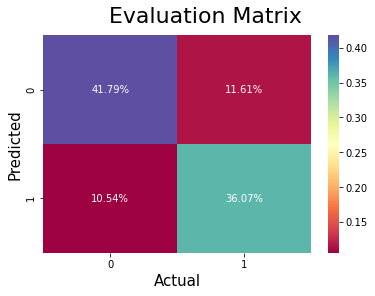

In [44]:
# Evaluation Matrix
train_predictions = model.predict(train_inputs)
cm = confusion_matrix(train_targets,train_predictions)
sns.heatmap(cm/np.sum(cm),annot=True,cmap="Spectral", fmt='.2%')
plt.xlabel("Actual",fontsize=15)
plt.ylabel("Predicted",fontsize=15)
plt.suptitle("Evaluation Matrix",fontsize=22)
plt.show()

### Summary table

In [22]:
feature_names = unscaled_inputs.columns.values
feature_names = feature_names.reshape(-1,1)
weights = model.coef_.T

feature_names.shape,weights.shape

((11, 1), (11, 1))

In [23]:
summary_table = pd.DataFrame( np.column_stack([feature_names,weights]) , columns=["Parameters","Weights"])

df = pd.DataFrame({"Parameters":["Intercept"] , "Weights":[model.intercept_[0]]})
summary_table = pd.concat( [df,summary_table],ignore_index=True)

summary_table["Odds Ratio"] = summary_table.Weights.apply(lambda x: np.exp(x))

summary_table.sort_values("Odds Ratio",ascending=False)

,Parameters,Weights,Odds Ratio
3,Reason_3,3.09889,22.173357
1,Reason_1,2.91625,18.471885
4,Reason_4,0.966985,2.630004
2,Reason_2,0.779945,2.181353
5,Transportation Expense,0.673825,1.961727
10,Children,0.40093,1.493213
8,Body Mass Index,0.267856,1.307158
6,Distance to Work,-0.0773094,0.925603
7,Age,-0.269305,0.763910
11,Pets,-0.292697,0.746248


<div class="alert-info alert">
<h2>Insights Drawn:-</h2>

<div style="font-size:13px" >

<ul >
<code>
<li><code>Intercept is just to reduce the error terms and increase accuracy , no any kind of interpretability is there for intercept </code></li>

<li><code>Reason for Absence is the largest explanatory variable. For ex- If a person has given a Reason_3 , odds of absence increases 22 times nearly </code></li>
     
<li><code>Month Value,Day of the Week and other parameters whose weight is nearly zero has no effect on model so dropping those columns simplify our model</code></li>
    
<li><code>For **Children** the odds of absence increases when a standarized unit of children increases(Can be interpreted as It is more likely to absent when number of child increases, since they are absent more likely to take care of their children)</code></li>
    
<li><code>For **Pets**,Education and other parameters with negative weights , odds of absence decreases( Can be interpreted as It is less likely to absent when Pets increases, since pets play among each others and stay healthy or there is someone to take care</code></li>
</code> 
</ul>
</div>
</div>

### Testing the Model

In [24]:
# Corresponding probabilities
predicted_proba = pd.DataFrame(model.predict_proba(test_inputs) , columns=["Class 0","Class 1"])
predicted_proba

,Class 0,Class 1
0,0.823556,0.176444
1,0.865588,0.134412
2,0.794716,0.205284
3,0.593142,0.406858
4,0.593898,0.406102
...,...,...
135,0.064356,0.935644
136,0.472333,0.527667
137,0.358527,0.641473
138,0.593898,0.406102


In [25]:
# Model Accuracy
model_accuracy = model.score(test_inputs,test_targets)*100
print("Model Accuracy : {0: 0.2f} %".format(model_accuracy))


Model Accuracy :  77.86 %


### Save the model

In [26]:
import pickle

with open("Model","wb") as file:
     pickle.dump(model,file)

with open("Scaler","wb") as file:
     pickle.dump(scaler,file)
